<a href="https://colab.research.google.com/github/zeekgwang/WM-811K/blob/main/classification/WM811K_Classification_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os.path import join

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

np.random.seed(0)

In [ ]:
data_path = "./drive/MyDrive/wafer/wm811k/"
print(os.listdir(data_path))

['LSWMD.pkl', 'y_3000.npy', 'x_3000.npy', 'y_3500.npy', 'x_3500.npy', 'x_3500_128.npy', 'y_3500_128.npy']


In [ ]:
x_3500 = np.load(data_path + "x_3500.npy")
y_3500 = np.load(data_path + "y_3500.npy")
y_3500 = y_3500.argmax(axis=1).reshape(-1,1)

In [ ]:
print(f"x_3500.shape : {x_3500.shape}")
print(f"y_3500.shape : {y_3500.shape}")

x_3500.shape : (3500, 3, 28, 28)
y_3500.shape : (3500, 1)


In [ ]:
x_train, x_test, y_train, y_test \
= train_test_split(x_3500, y_3500,
                   test_size = 0.2,
                   shuffle=True)

In [ ]:
print(f"x_train.shape : {x_train.shape}")
print(f"x_test.shape : {x_test.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"y_test.shape : {y_test.shape}")

x_train.shape : (2800, 3, 28, 28)
x_test.shape : (700, 3, 28, 28)
y_train.shape : (2800, 1)
y_test.shape : (700, 1)


In [ ]:
batch_size = 1024

In [ ]:
def get_device():
  if torch.cuda.is_available():
    device = 'cuda:0'
  else:
    device = 'cpu'
  return device

device = get_device()
print(device)

cuda:0


In [ ]:
class WaferMapDataset(Dataset):
  def __init__(self, x, y, transform = None):
    super().__init__()
    self.x = x
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    x_idx = self.x[idx]
    # print(x_idx.shape)
    image = Image.fromarray((x_idx * 255).astype(np.uint8).transpose((1,2,0)))    
    # print(np.array(image).shape)
    if self.transform:
      image = self.transform(image)

    x_idx = np.array(image) / 255
    x_idx = x_idx.transpose((2,0,1))
    # print(x_idx.shape)
    return torch.FloatTensor(x_idx), torch.LongTensor(self.y[idx])

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30)
])

In [ ]:
waferMapDataset = WaferMapDataset(x_train, y_train, transform = transform)
# waferMapDataset = WaferMapDataset(x_train, y_train)

In [ ]:
train_loader = DataLoader(waferMapDataset, batch_size=batch_size)

In [ ]:
data_iter = iter(train_loader)
x_head, y_head = data_iter.next()

In [ ]:
print(f"type(x_head) : {type(x_head)},\ntype(y_head) : {type(y_head)}")

type(x_head) : <class 'torch.Tensor'>,
type(y_head) : <class 'torch.Tensor'>


In [ ]:
print(f"x_head.shape : {x_head.shape},\ny_head.shape : {y_head.shape}")

x_head.shape : torch.Size([1024, 3, 28, 28]),
y_head.shape : torch.Size([1024, 1])


Text(0.5, 1.0, 'tensor([5])')

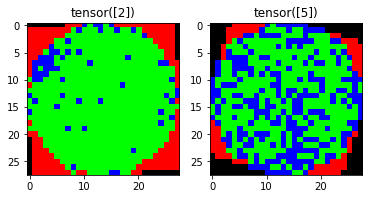

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(np.transpose(x_head[0], (1,2,0)))
ax1.set_title(y_head[0])


ax2.imshow(np.transpose(x_head[1], (1,2,0)))
ax2.set_title(y_head[1])

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

    self.pool = nn.MaxPool2d(2, 2)
    self.flat = nn.Flatten()

    self.fc1 = nn.Linear(6272, 128)
    self.fc2 = nn.Linear(128, 7)

  def forward(self, x):
    x = F.relu((self.conv1(x)))
    x = self.pool(x)
    x = F.relu((self.conv2(x)))
    x = self.pool(x)
    x = F.relu((self.conv3(x)))

    x = self.flat(x)

    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x))

    return x

In [ ]:
model = ConvNet().to(device)
model

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
from torchsummary import summary as summary_
summary_(model.to(device), (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
           Flatten-6                 [-1, 6272]               0
            Linear-7                  [-1, 128]         802,944
            Linear-8                    [-1, 7]             903
Total params: 897,095
Trainable params: 897,095
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.46
Params size (MB): 3.42
Estimated Total Size (MB): 3.89
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
x_test = torch.FloatTensor(x_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [ ]:
for epoch in range(100):

    running_loss = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.reshape(-1).to(device)
        # y = torch.tensor(y, dtype=torch.long, device=device)
        
        optimizer.zero_grad()

        outputs = model(x)
        # print(outputs.shape)
        # print(y.shape)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test.reshape(-1)
    accuracy = correct_prediction.float().mean()

    print('[%d] loss: %.3f  validation accuracy: %f' %
          (epoch + 1, running_loss , accuracy.item()))

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1] loss: 5.819  validation accuracy: 0.145714
[2] loss: 5.643  validation accuracy: 0.395714
[3] loss: 5.299  validation accuracy: 0.490000
[4] loss: 4.990  validation accuracy: 0.561429
[5] loss: 4.816  validation accuracy: 0.621429
[6] loss: 4.739  validation accuracy: 0.595714
[7] loss: 4.689  validation accuracy: 0.638571
[8] loss: 4.633  validation accuracy: 0.592857
[9] loss: 4.553  validation accuracy: 0.708571
[10] loss: 4.483  validation accuracy: 0.588571
[11] loss: 4.462  validation accuracy: 0.721429
[12] loss: 4.420  validation accuracy: 0.708571
[13] loss: 4.372  validation accuracy: 0.662857
[14] loss: 4.341  validation accuracy: 0.702857
[15] loss: 4.309  validation accuracy: 0.715714
[16] loss: 4.288  validation accuracy: 0.732857
[17] loss: 4.260  validation accuracy: 0.734286
[18] loss: 4.245  validation accuracy: 0.735714
[19] loss: 4.209  validation accuracy: 0.742857
[20] loss: 4.200  validation accuracy: 0.744286
[21] loss: 4.172  validation accuracy: 0.752857
[

In [ ]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    # x_test = torch.FloatTensor(x_test).to(device)
    # y_test = torch.LongTensor(y_test).to(device)

    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test.reshape(-1)
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.868571400642395


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(torch.argmax(prediction, 1).cpu(), y_test.reshape(-1).cpu())
print(cf)

[[ 99   0   3   0   4   1   2]
 [  0  91   1   0   0   3   2]
 [  1   1  75   3   8   0   5]
 [  0   0   3 105   0   0   1]
 [  3   0   5   0  73   1  10]
 [  1   1   2   0   2  92   0]
 [  1   1   8   1  18   0  73]]


In [ ]:
prediction[598]

tensor([1.0433e-18, 2.6911e-22, 2.7797e-16, 8.1246e-21, 2.0848e-26, 1.0000e+00,
        3.0381e-27], device='cuda:0')

In [ ]:
torch.argmax(prediction, 1)

tensor([0, 0, 5, 5, 3, 2, 3, 3, 1, 1, 2, 4, 6, 0, 6, 0, 0, 5, 2, 3, 0, 5, 4, 3,
        6, 0, 1, 1, 2, 1, 1, 1, 5, 5, 6, 0, 1, 1, 3, 4, 1, 5, 0, 5, 0, 2, 6, 4,
        1, 1, 4, 5, 1, 2, 1, 2, 4, 2, 3, 0, 1, 2, 3, 1, 2, 4, 5, 3, 6, 1, 1, 1,
        3, 3, 2, 5, 4, 0, 3, 2, 6, 2, 6, 4, 2, 4, 4, 2, 1, 1, 1, 0, 4, 2, 3, 5,
        4, 1, 5, 5, 0, 3, 1, 0, 4, 5, 2, 6, 4, 1, 2, 6, 5, 1, 1, 2, 0, 6, 0, 0,
        3, 4, 1, 3, 1, 6, 4, 6, 1, 5, 1, 6, 4, 3, 3, 5, 5, 0, 6, 5, 6, 2, 1, 0,
        4, 6, 6, 4, 5, 5, 5, 3, 4, 3, 4, 1, 1, 1, 3, 4, 2, 1, 5, 1, 6, 1, 0, 3,
        5, 5, 3, 2, 5, 1, 5, 4, 3, 6, 2, 4, 1, 1, 5, 5, 5, 3, 4, 1, 4, 4, 5, 3,
        5, 0, 5, 5, 3, 6, 3, 0, 5, 0, 5, 1, 6, 1, 1, 4, 3, 2, 0, 1, 5, 1, 2, 5,
        2, 6, 3, 2, 5, 4, 1, 5, 2, 6, 2, 0, 5, 6, 6, 4, 2, 4, 5, 5, 0, 6, 0, 3,
        5, 4, 4, 2, 0, 4, 2, 1, 0, 6, 2, 6, 2, 1, 2, 5, 5, 1, 0, 3, 1, 3, 0, 3,
        6, 1, 6, 0, 5, 5, 5, 1, 1, 1, 0, 5, 4, 4, 0, 0, 2, 5, 0, 5, 0, 1, 2, 6,
        1, 4, 1, 5, 2, 5, 4, 5, 3, 1, 1,

In [ ]:
y_test.reshape(-1)

tensor([2, 0, 5, 5, 3, 3, 3, 3, 1, 1, 2, 0, 6, 0, 6, 0, 6, 2, 2, 3, 0, 5, 4, 3,
        6, 0, 1, 1, 2, 1, 1, 1, 5, 5, 6, 0, 1, 1, 3, 4, 1, 5, 0, 5, 0, 2, 6, 4,
        1, 1, 6, 5, 1, 3, 1, 2, 4, 2, 3, 0, 1, 2, 3, 1, 2, 6, 5, 3, 6, 1, 1, 1,
        3, 3, 2, 5, 4, 0, 2, 2, 6, 2, 4, 4, 2, 4, 0, 2, 1, 1, 1, 0, 4, 2, 3, 5,
        4, 1, 5, 5, 0, 3, 1, 0, 4, 5, 4, 6, 0, 1, 2, 6, 5, 1, 1, 2, 0, 6, 0, 0,
        3, 4, 1, 3, 1, 6, 1, 6, 1, 5, 1, 6, 4, 3, 3, 5, 5, 0, 6, 5, 6, 2, 1, 0,
        4, 6, 6, 4, 5, 5, 5, 3, 4, 3, 4, 1, 1, 1, 3, 4, 2, 1, 5, 1, 4, 1, 0, 3,
        5, 5, 3, 2, 5, 1, 5, 4, 3, 4, 2, 4, 5, 1, 5, 5, 5, 3, 4, 1, 4, 4, 5, 3,
        5, 0, 5, 5, 3, 6, 3, 0, 5, 0, 5, 1, 2, 1, 5, 6, 3, 2, 4, 1, 5, 1, 2, 5,
        2, 6, 3, 2, 5, 0, 1, 5, 2, 6, 4, 0, 5, 6, 6, 6, 2, 4, 5, 5, 0, 0, 0, 3,
        5, 6, 4, 2, 0, 4, 2, 1, 0, 6, 2, 6, 4, 1, 2, 5, 5, 4, 0, 3, 6, 3, 0, 3,
        6, 1, 6, 0, 5, 5, 5, 1, 1, 1, 0, 2, 2, 6, 0, 0, 3, 5, 0, 5, 0, 1, 2, 6,
        1, 6, 1, 5, 2, 5, 4, 5, 3, 1, 1,